# Drug plates

In [1]:
library(ggplot2)
library(extrafont)
library(stringr)
library(heatmaply)
library(ggrepel)
library(reticulate)
library(gridExtra)

Registering fonts with R
Loading required package: plotly

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Loading required package: viridis
Loading required package: viridisLite

Welcome to heatmaply version 0.15.2

Type citation('heatmaply') for how to cite the package.
Type ?heatmaply for the main documentation.

The github page is: https://github.com/talgalili/heatmaply/
Please submit your suggestions and bug-reports at: https://github.com/talgalili/heatmaply/issues
Or contact: <tal.galili@gmail.com>



In [2]:
# Fix t-SNE layout and random number generation
set.seed(38)
# Load external Python functions
source_python("reticulate_functions.py")
# Load extra fonts
loadfonts()

Sys TT already registered with pdfFonts().
Lato Black already registered with pdfFonts().
Lato already registered with pdfFonts().
Lato Hairline already registered with pdfFonts().
Lato Light already registered with pdfFonts().
.Keyboard already registered with pdfFonts().
More than one version of regular/bold/italic found for System Font. Skipping setup for this font.
Andale Mono already registered with pdfFonts().
More than one version of regular/bold/italic found for Apple Braille. Skipping setup for this font.
AppleMyungjo already registered with pdfFonts().
Arial Black already registered with pdfFonts().
Arial already registered with pdfFonts().
Arial Narrow already registered with pdfFonts().
Arial Rounded MT Bold already registered with pdfFonts().
Arial Unicode MS already registered with pdfFonts().
Bodoni Ornaments already registered with pdfFonts().
Bodoni 72 Smallcaps already registered with pdfFonts().
No regular (non-bold, non-italic) version of . Skipping setup for this f

In [3]:
# Customize ggplot appearance

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}


cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
scale_fill_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)

## NK92

In [4]:
NK = read.csv("./allImages_NK_Drugs.csv", header=T)

In [5]:
Layout = read.csv("./DrugPlateLayout.csv", header=T)
Layout$Well <- paste0(Layout$Row, str_pad(Layout$Column, 2, pad = "0"))

In [7]:
NK$Drug = sapply(NK$Metadata_Well, function(x) Layout$Drug[x == Layout$Well])
NK$Concentration = sapply(NK$Metadata_Well, function(x) Layout$Concentration[x == Layout$Well])

Saving 7 x 7 in image


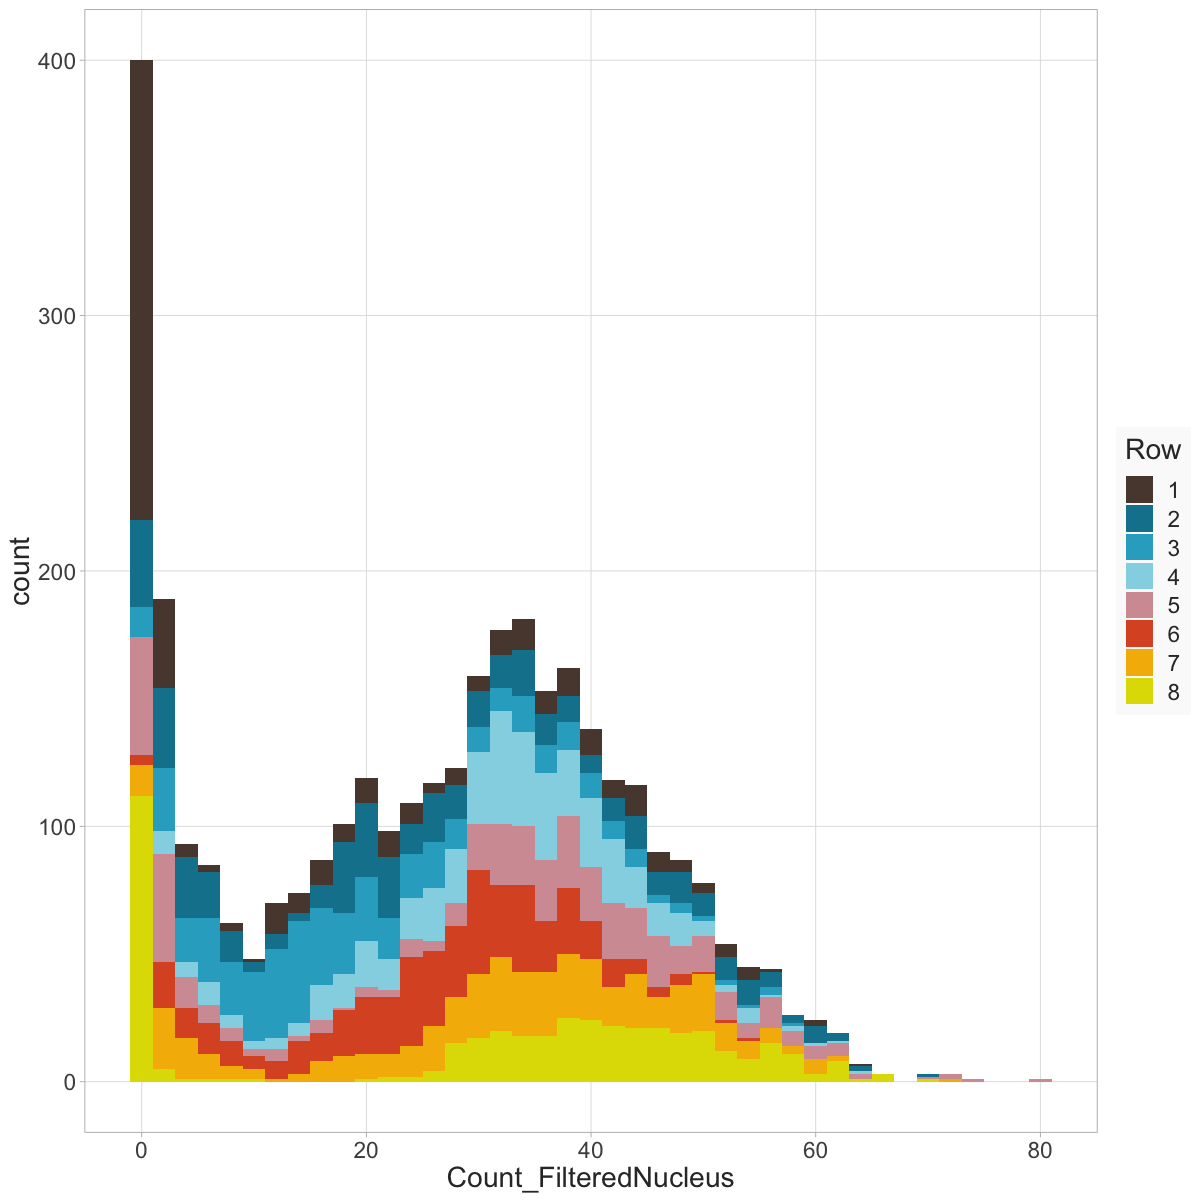

In [8]:
gpNK = ggplot(NK[!is.na(NK$Count_FilteredNucleus),]) + geom_histogram(aes(Count_FilteredNucleus, fill = as.factor(Metadata_Row)), binwidth=2) +
       scale_fill_discrete(name="Row")
gpNK
ggsave(filename = "countNK.pdf", plot = gpNK)

Saving 7 x 7 in image


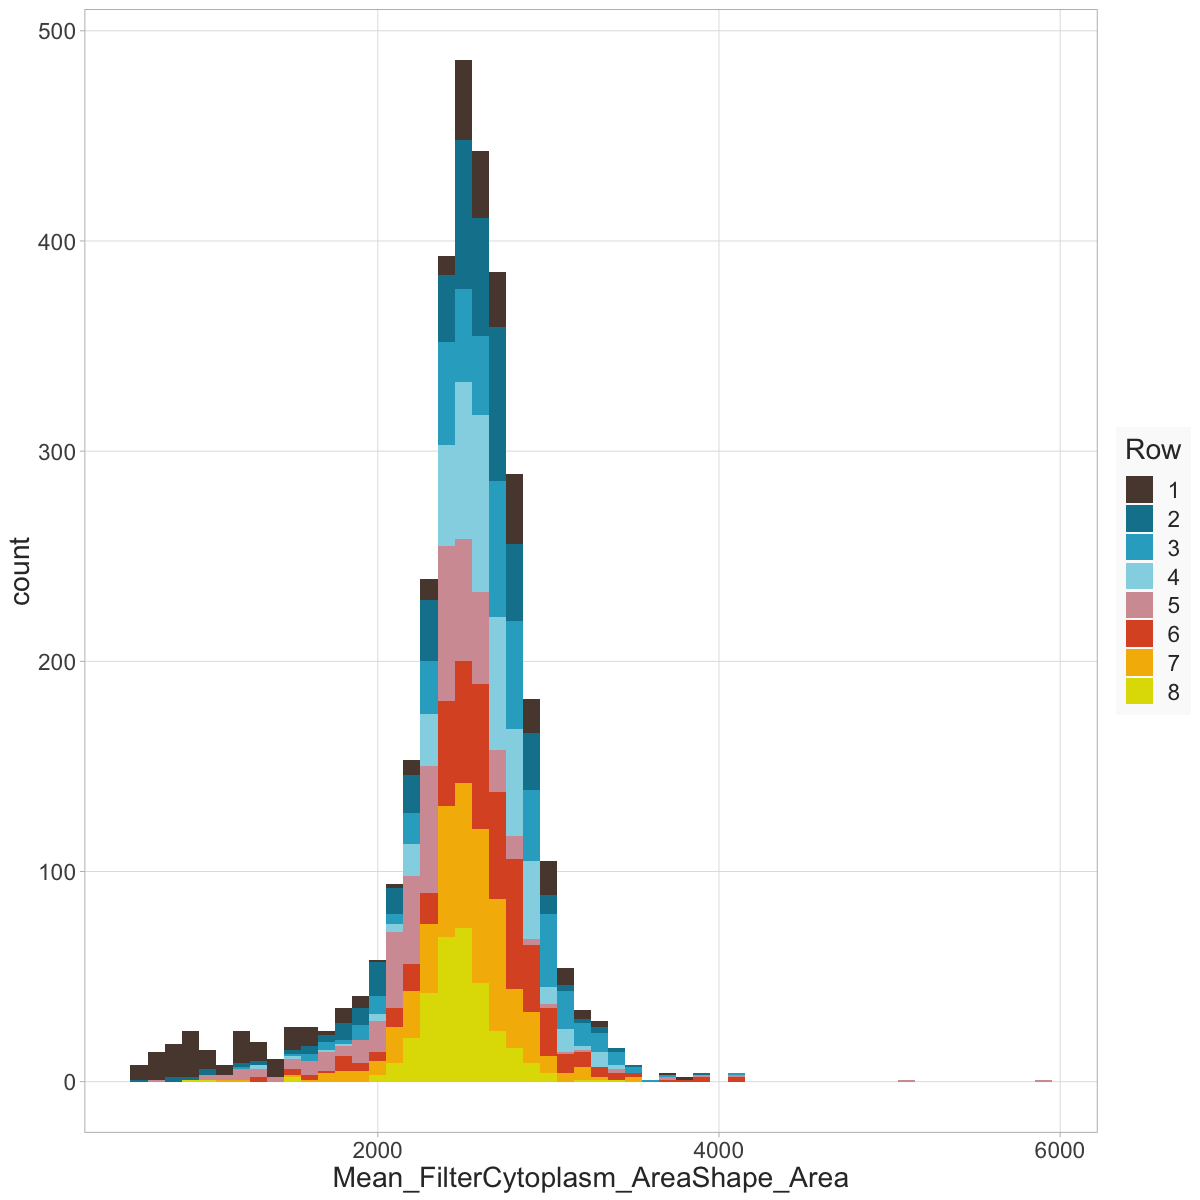

In [9]:
gpNK = ggplot(NK[!is.na(NK$Mean_FilterCytoplasm_AreaShape_Area),]) + geom_histogram(aes(Mean_FilterCytoplasm_AreaShape_Area, 
                                                                                    fill = as.factor(Metadata_Row)), binwidth=100) +
       scale_fill_discrete(name="Row")
gpNK
ggsave(filename = "areaNK.pdf", plot = gpNK)

### Filtering

In [10]:
FILT_MAX_INT_DNA = 0.05 # Remove empty images and small DNA precipitations
FILT_MIN_CELLS = 4 # 8 seems safe from distribution and images, 3 seems in poor shape
FILT_NB_MAX_NA_IMAGE = 10 # 48 images generated between 10 and 385 NAs/image, all others generate at most 2/image

In [11]:
ftToKeep = 1:dim(NK)[2]
# Make sure that the fields are numeric
ftToKeep <- ftToKeep[which(sapply(NK[,ftToKeep], class) == "numeric")]
# Remove execution time and count features
ftToKeep <- ftToKeep[grep("(Execution)|(Count)", colnames(NK)[ftToKeep], invert = T)]

In [12]:
# Remove wells with low max DNA intensity
fieldToKeep <- which(NK$ImageQuality_MaxIntensity_DNA >= FILT_MAX_INT_DNA)
# Remove wells with low cell count
fieldToKeep <- fieldToKeep[NK[fieldToKeep,]$Count_FilteredNucleus >= FILT_MIN_CELLS]

In [13]:
# Few bad quality pictures are generating a lot of missing values and are removed
fieldToKeep <- fieldToKeep[rowSums(is.na(NK[fieldToKeep,ftToKeep])) < FILT_NB_MAX_NA_IMAGE]
# Remove remaining features with missing values
ftToKeep <- ftToKeep[colSums(is.na(NK[fieldToKeep,ftToKeep])) == 0] 
# Remove constant columns
ftToKeep <- ftToKeep[sapply(NK[fieldToKeep,ftToKeep], function(x) sd(x) != 0)]
ftToKeep <- ftToKeep[sapply(NK[fieldToKeep,ftToKeep], function(x) mad(x) != 0)]

In [14]:
print(dim(NK))
print(length(ftToKeep))
print(length(fieldToKeep))

[1] 3520 1945
[1] 1857
[1] 2872


In [15]:
transfLog <- function (x){
    minVal = min(x)
    return(log(x+1-minVal))
}

transfNorm <- function(x){
    return((x - median(x))/mad(x))
}

In [16]:
transformedNK = apply(NK[fieldToKeep, ftToKeep], 2, transfLog)
transformedNK = apply(transformedNK, 2, transfNorm)

In [17]:
umTNK = umap(transformedNK, min_dist = 0.1, neighbors = 10)
umTNK = as.data.frame(umTNK)
names(umTNK) = c("UMAP1", "UMAP2")
umTNK$Row <- as.factor(NK$Metadata_Row[fieldToKeep])
umTNK$Col <- as.factor(NK$Metadata_Column[fieldToKeep])
umTNK$Drug <- as.factor(NK$Drug[fieldToKeep])
umTNK$Conc <- as.factor(NK$Concentration[fieldToKeep])
umTNK$URL <- as.factor(NK$URL_Actin[fieldToKeep])

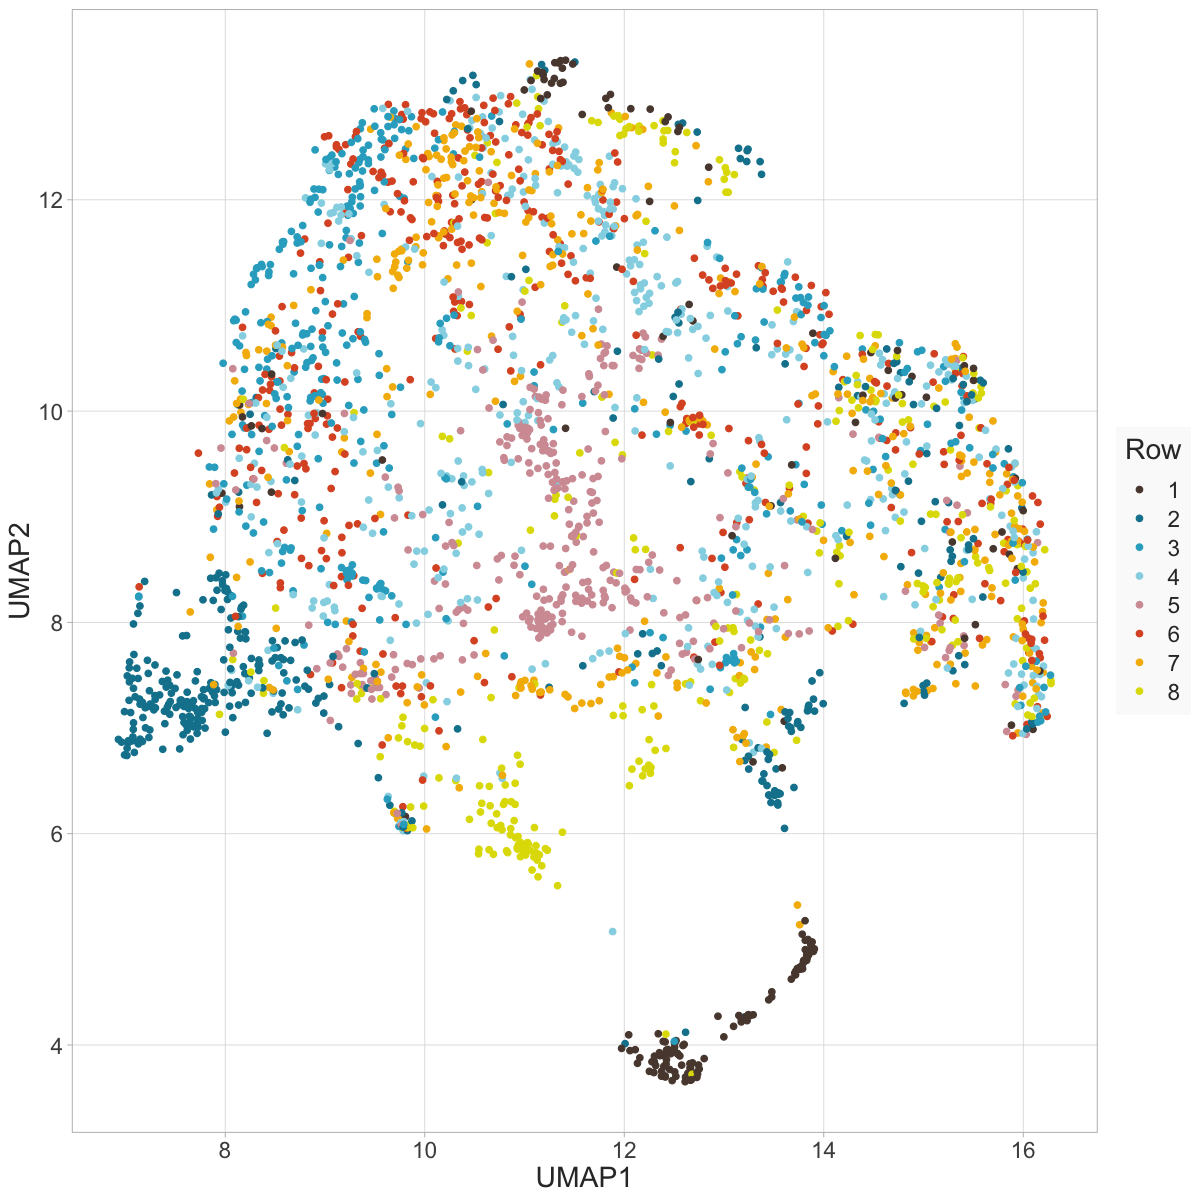

In [18]:
ggplot(umTNK) + geom_point(aes(UMAP1, UMAP2, color = Row))

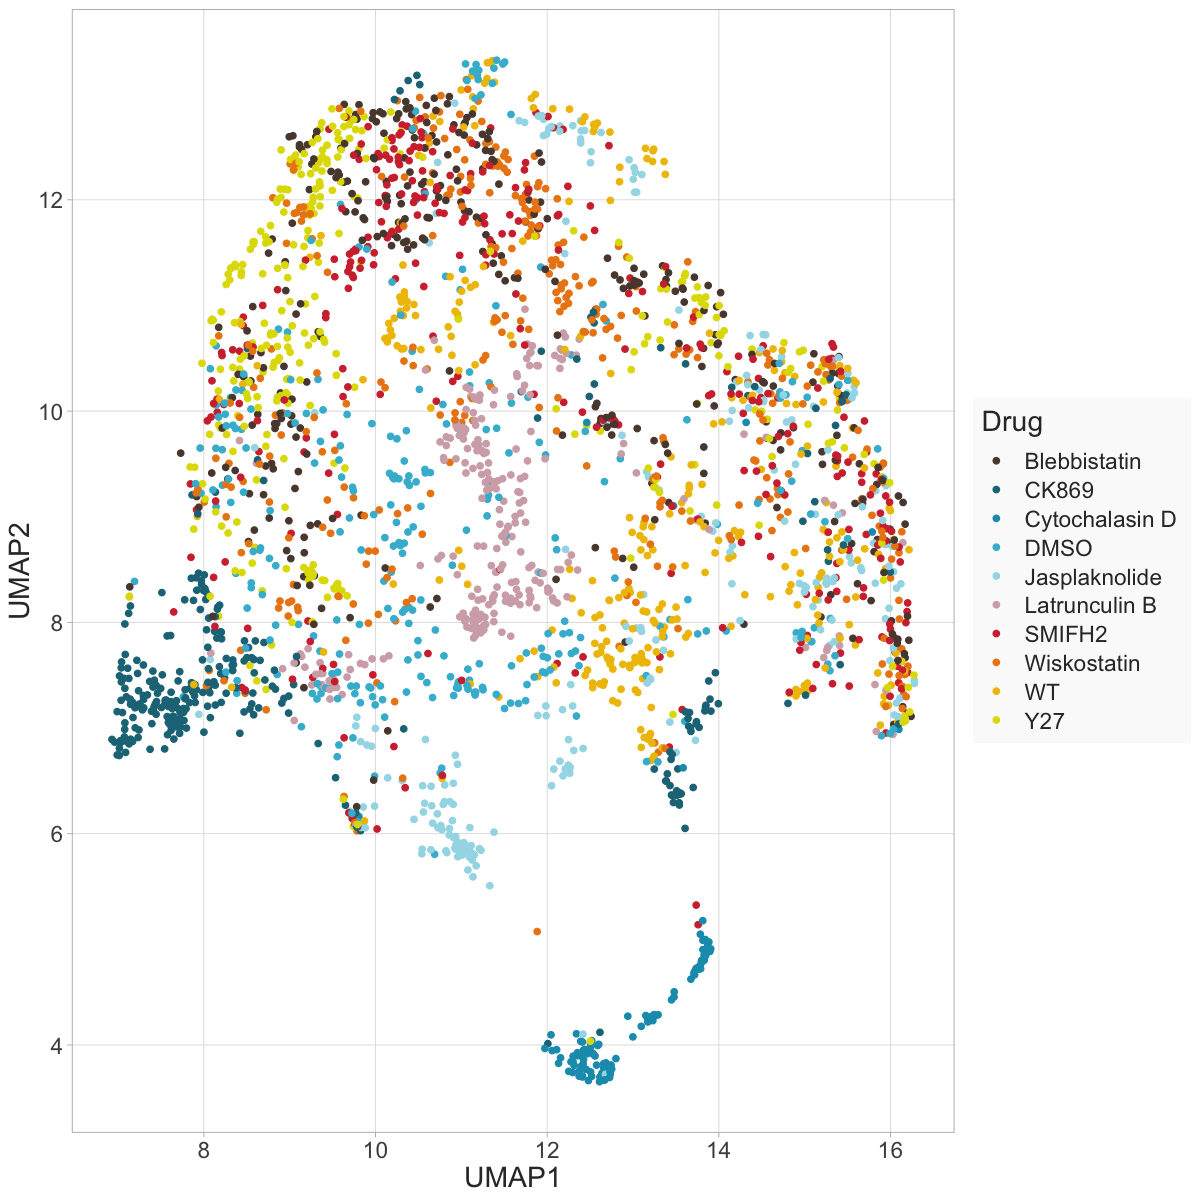

In [19]:
ggplot(umTNK) + geom_point(aes(UMAP1, UMAP2, color = Drug))

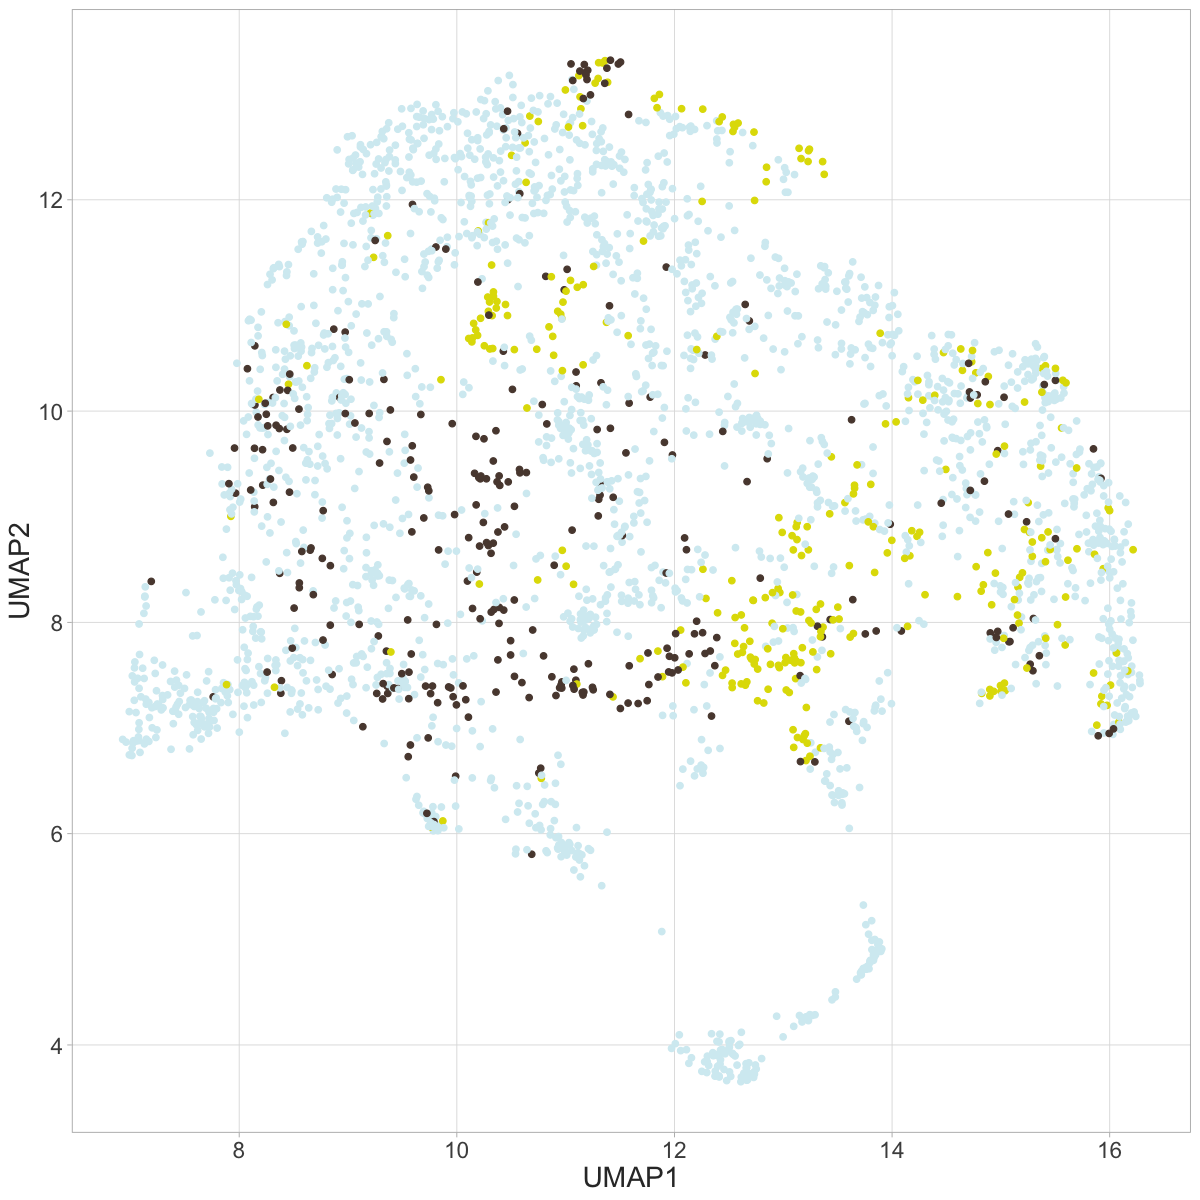

In [26]:
ggplot(umTNK) + geom_point(aes(UMAP1, UMAP2, color = ifelse(Drug == "DMSO", "DMSO", ifelse(Drug == "WT", "WT", "Drug")))) + 
    guides(color=FALSE)

In [21]:
umNK = umap(NK[fieldToKeep, ftToKeep])
umNK = as.data.frame(umNK)
names(umNK) = c("UMAP1", "UMAP2")
umNK$Row <- as.factor(NK$Metadata_Row[fieldToKeep])
umNK$Col <- as.factor(NK$Metadata_Column[fieldToKeep])
umNK$Drug <- as.factor(NK$Drug[fieldToKeep])
umNK$Conc <- as.factor(NK$Concentration[fieldToKeep])
umNK$URL <- as.factor(NK$URL_Actin[fieldToKeep])

In [ ]:
ggplot(umNK) + geom_point(aes(UMAP1, UMAP2, color = Drug))

In [ ]:
ggplot(umNK) + geom_point(aes(UMAP1, UMAP2, color = Row))

In [ ]:
ggplot(umNK) + geom_point(aes(UMAP1, UMAP2, color = Col))

## Jurkat

In [27]:
JK = read.csv("./allImages_Jurkat_Drugs.csv", header=T)

In [28]:
JK$Drug = sapply(JK$Metadata_Well, function(x) Layout$Drug[x == Layout$Well])
JK$Concentration = sapply(JK$Metadata_Well, function(x) Layout$Concentration[x == Layout$Well])

Saving 7 x 7 in image


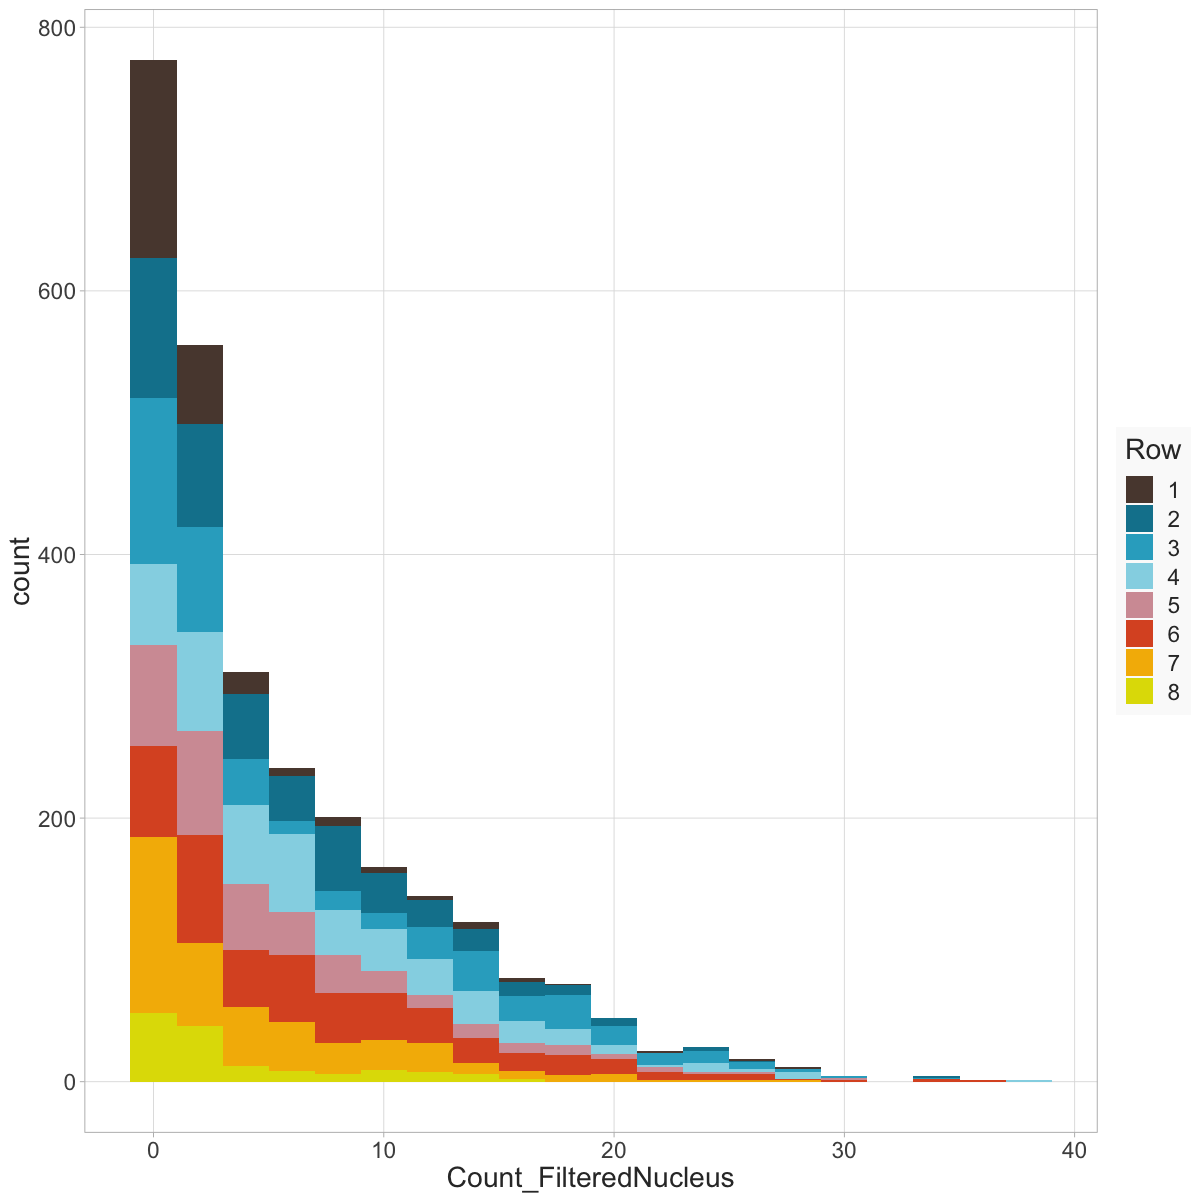

In [29]:
gpJK = ggplot(JK[!is.na(JK$Count_FilteredNucleus),]) + geom_histogram(aes(Count_FilteredNucleus, fill = as.factor(Metadata_Row)), binwidth=2) +
       scale_fill_discrete(name="Row")
gpJK
ggsave(filename = "countJK.pdf", plot = gpJK)

Saving 7 x 7 in image


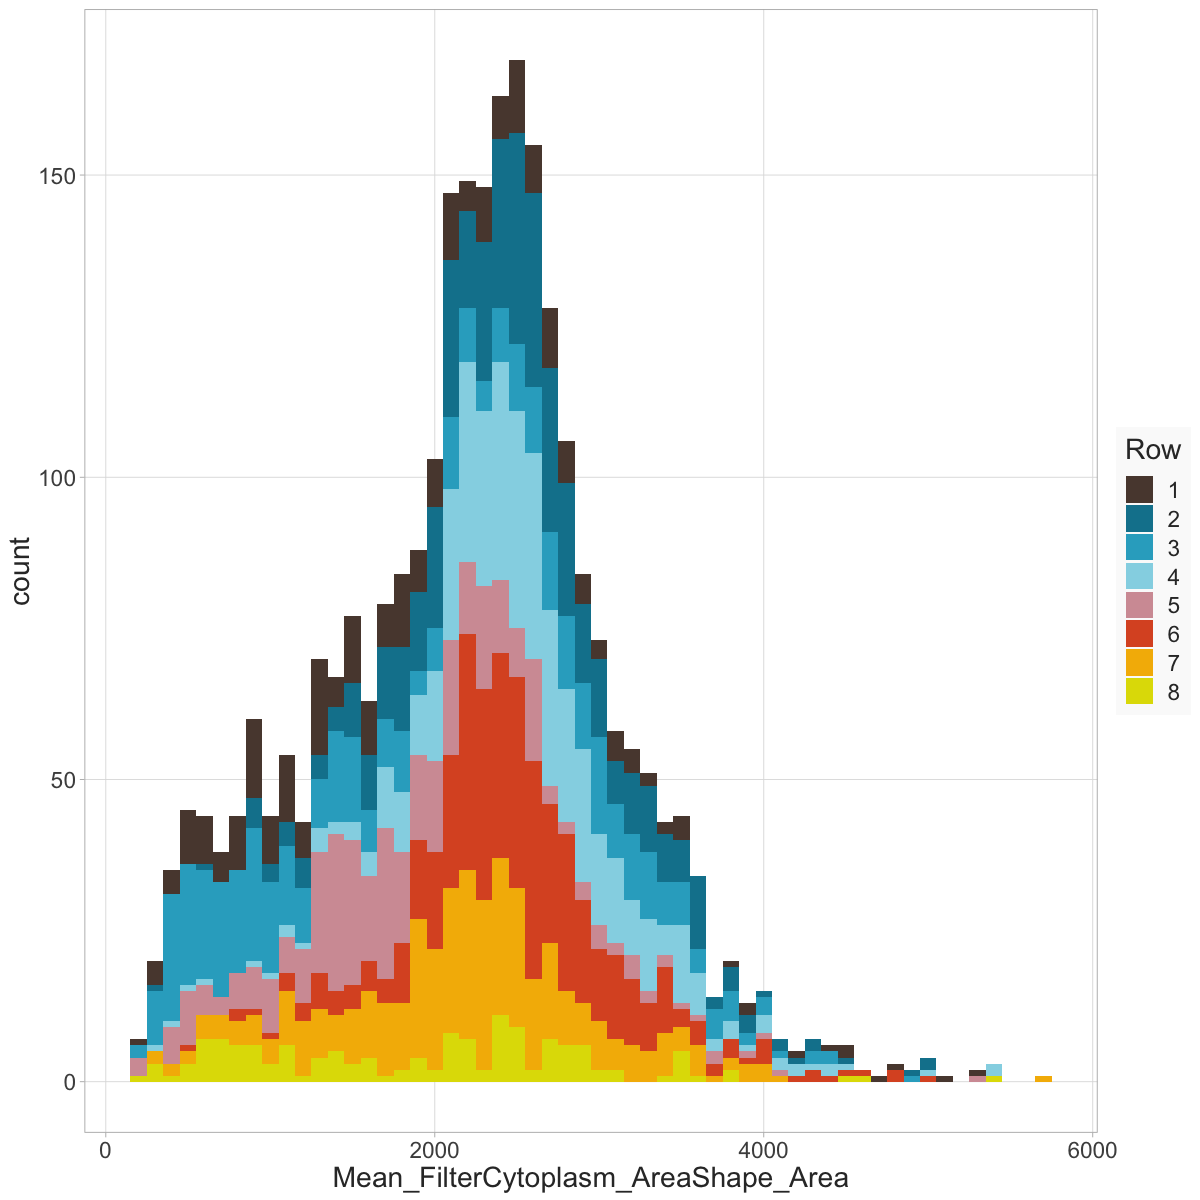

In [30]:
gpJK = ggplot(JK[!is.na(JK$Mean_FilterCytoplasm_AreaShape_Area),]) + geom_histogram(aes(Mean_FilterCytoplasm_AreaShape_Area, 
                                                                                    fill = as.factor(Metadata_Row)), binwidth=100) +
       scale_fill_discrete(name="Row")
gpJK
ggsave(filename = "areaJK.pdf", plot = gpJK)

In [81]:
FILT_MAX_INT_DNA = 0.05 # Remove empty images and small DNA precipitations
FILT_MIN_CELLS = 2 # 1 cell 
FILT_NB_MAX_NA_IMAGE = 50 # 48 images generated between 10 and 385 NAs/image, all others generate at most 2/image
# >= 352 NAs 5/6 bad images
# >= 82 NAs 4/6 bad images
# < 82 NAs 3/6 bad images + 1 single-cell image

In [58]:
length(which(JK$ImageQuality_MaxIntensity_DNA >= FILT_MAX_INT_DNA))
length(fieldToKeep[rowSums(is.na(JK[fieldToKeep,ftToKeep])) < FILT_NB_MAX_NA_IMAGE])
table(rowSums(is.na(JK[fieldToKeep,ftToKeep])))
table(rowSums(is.na(JK[fieldToKeep,ftToKeep])) > 23)
head(rowSums(is.na(JK[,ftToKeep])))

[1] 2935

[1] 402


   0    1    2    3   10   14   15   22   23   60   61   62   70   82   83  142 
 188   11  186   17   15   14    1 1222  135    4    1   17    2  180   19    1 
 348  349  352  353  397  398  412  457  458  728  729 1208 1223 1283 1554 1858 
   5    2  625   97   16    7    4    2    2    9    2    1    5    3    4  128 
1859 
  10 


FALSE  TRUE 
 1789  1146 

[1]  22   0   0 352  22  22

In [116]:
length(fieldToKeep)

[1] 2022

In [115]:
table(rowSums(is.na(JK[fieldToKeep,ftToKeep])))


  0   1   2   3  10  14  15  22  23  60  61  62  82  83 348 349 352 353 397 398 
183  11 179  15  15  12   1 858  98   4   1  17 139  13   2   1 396  74   1   1 
729 
  1 

In [112]:
paste(paste0(str_extract(string = JK[sample(which(rowSums(is.na(JK[fieldToKeep,ftToKeep])) >= 82), size = 6, replace = F),]$URL_Actin,
            pattern = "r..c..f.."), "*.tiff"), collapse = ' ')

[1] "r01c06f34*.tiff r05c04f13*.tiff r03c05f03*.tiff r03c06f23*.tiff r02c08f05*.tiff r08c01f39*.tiff"

In [113]:
paste(paste0(str_extract(string = JK[sample(which(rowSums(is.na(JK[fieldToKeep,ftToKeep])) >= 352), size = 6, replace = F),]$URL_Actin,
            pattern = "r..c..f.."), "*.tiff"), collapse = ' ')

[1] "r05c11f30*.tiff r05c05f10*.tiff r05c03f04*.tiff r04c09f12*.tiff r07c07f17*.tiff r05c09f22*.tiff"

In [114]:
paste(paste0(str_extract(string = JK[sample(which(rowSums(is.na(JK[fieldToKeep,ftToKeep])) < 82), size = 6, replace = F),]$URL_Actin,
            pattern = "r..c..f.."), "*.tiff"), collapse = ' ')

[1] "r05c07f07*.tiff r02c09f26*.tiff r02c04f15*.tiff r01c01f10*.tiff r07c08f15*.tiff r07c03f13*.tiff"

In [91]:
ftToKeep = 1:dim(JK)[2]
# Make sure that the fields are numeric
ftToKeep <- ftToKeep[which(sapply(JK[,ftToKeep], class) == "numeric")]
# Remove execution time and count features
ftToKeep <- ftToKeep[grep("(Execution)|(Count)", colnames(JK)[ftToKeep], invert = T)]

In [92]:
# Remove wells with low max DNA intensity
fieldToKeep <- which(JK$ImageQuality_MaxIntensity_DNA >= FILT_MAX_INT_DNA)
# Remove wells with low cell count
fieldToKeep <- fieldToKeep[!is.na(JK[fieldToKeep,]$Count_FilteredNucleus)]
fieldToKeep <- fieldToKeep[JK[fieldToKeep,]$Count_FilteredNucleus >= FILT_MIN_CELLS]

In [43]:
# Few bad quality pictures are generating a lot of missing values and are removed
fieldToKeep <- fieldToKeep[rowSums(is.na(JK[fieldToKeep,ftToKeep])) < FILT_NB_MAX_NA_IMAGE]
# Remove remaining features with missing values
ftToKeep <- ftToKeep[colSums(is.na(JK[fieldToKeep,ftToKeep])) == 0] 
# Remove constant columns
ftToKeep <- ftToKeep[sapply(JK[fieldToKeep,ftToKeep], function(x) sd(x) != 0)]
ftToKeep <- ftToKeep[sapply(JK[fieldToKeep,ftToKeep], function(x) mad(x) != 0)]

In [96]:
print(dim(JK))
print(length(ftToKeep))
print(length(fieldToKeep))

[1] 3171 1942
[1] 1896
[1] 2022


In [ ]:
sessionInfo()